In [136]:
import pandas as pd
import numpy as np
import re
import string
from tqdm.auto import tqdm
from functools import lru_cache
import langid
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, ParameterGrid, train_test_split
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.sparse import hstack
from joblib import dump, load
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestRegressor

from datetime import datetime
import os
tqdm.pandas()
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [157]:
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore


In [121]:
MIN_TEXT_LENGTH = 10
SHORT_TEXT_THRESHOLDS = {
    'description': 20,
    'neighborhood_overview': 10,
    'host_about': 10,
    'comments': 50
}
DATA_DIR = "airbnb data"
MODEL_DIR = "models"
RESULTS_DIR = "results"

for dir_path in [MODEL_DIR, RESULTS_DIR]:
    os.makedirs(dir_path, exist_ok=True)


# 1. Utility Functions

In [122]:
@lru_cache(maxsize=100_000)
def detect_language(text: str) -> str:
    if not isinstance(text, str) or len(text.strip()) < MIN_TEXT_LENGTH:
        return 'unknown'
    return langid.classify(text)[0]

def clean_and_lemmatize(texts, batch_size=64):
    if not texts:
        return []

    cleaned = []
    for text in texts:
        if pd.isna(text):
            cleaned.append("")
            continue

        text = str(text).lower() # lower case
        text = re.sub(r'<.*?>', ' ', text) # HTML tags
        text = text.translate(str.maketrans('', '', string.punctuation)) # punctuation
        text = re.sub(r'\s+', ' ', text).strip() # normalize white space
        cleaned.append(text)

    docs = list(nlp.pipe(cleaned, batch_size=batch_size))
    final_cleaned = []

    for doc in docs:
        lemmas = [token.lemma_ for token in doc
                 if not token.is_stop and token.is_alpha and len(token.lemma_) > 1] # stop words = 'a', 'the'...
        text = ' '.join(lemmas)
        text = re.sub(r'\s+', ' ', text).strip()
        final_cleaned.append(text)

    return final_cleaned

def calculate_text_statistics(df, text_columns):
    stats = {}
    for col in text_columns:
        text_data = df[col].fillna('')
        stats[col] = {
            'total_texts': len(text_data),
            'non_empty': (text_data.str.len() > 0).sum(),
            'avg_length': text_data.str.len().mean(),
            'median_length': text_data.str.len().median(),
            'max_length': text_data.str.len().max(),
            'unique_texts': text_data.nunique()
        }

    stats_df = pd.DataFrame(stats).T
    print("Text Statistics:")
    print(stats_df.round(2))
    return stats_df

# 2. Data Loading and Preprocessing

In [123]:
def load_and_merge_data():

    listings = pd.read_csv(f"{DATA_DIR}/listings.csv")[
        ['id', 'description', 'price', 'neighborhood_overview', 'host_about']
    ]
    reviews = pd.read_csv(f"{DATA_DIR}/reviews.csv")[['listing_id', 'comments']]

    listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)

    merged = listings.merge(reviews, left_on='id', right_on='listing_id', how='inner')
    merged = merged.drop(columns='listing_id')
    merged = merged.dropna(subset=['price'])

    print(f"Merged data shape: {merged.shape}")
    print(f"Price range: ${merged['price'].min():.2f} - ${merged['price'].max():.2f}")
    print(f"Median price: ${merged['price'].median():.2f}")

    return merged

def filter_english_and_aggregate(df):

    text_cols = ['description', 'neighborhood_overview', 'host_about', 'comments']

    for col in text_cols:
        print(f"  Processing {col}...")
        df[col] = df[col].fillna('').progress_apply(
            lambda x: x if detect_language(x) == 'en' else ''
        )

    print("  Aggregating reviews...")
    aggregated = df.groupby('id').agg({
        'description': 'first',
        'price': 'first',
        'neighborhood_overview': 'first',
        'host_about': 'first',
        'comments': lambda x: ' '.join(x.astype(str))
    }).reset_index()

    print(f"After filtering and aggregating: {aggregated.shape}")
    return aggregated

def preprocess_data(df):
    print("Preprocessing text data...")

    text_cols = ['description', 'neighborhood_overview', 'host_about', 'comments']

    calculate_text_statistics(df, text_cols)

    for col in text_cols:
        print(f"  Cleaning {col}...")
        texts = df[col].fillna('').tolist()
        cleaned = clean_and_lemmatize(texts)
        df[col] = cleaned

    print("  Filtering short texts...")
    initial_count = len(df)

    mask = sum(
        (df[col].str.len() > thresh)
        for col, thresh in SHORT_TEXT_THRESHOLDS.items()
    ) > 0

    df = df[mask].copy()
    removed_count = initial_count - len(df)

    print(f"Removed {removed_count} rows with insufficient text")
    print(f"Final dataset size: {len(df)} rows")

    return df

# 3. TF-IDF Optimization Functions

In [137]:
def optimize_tfidf_parameters(df, text_column, target_column='price',
                            max_features_range=[500, 1000, 2000],
                            max_df_range=[0.5, 0.7, 0.9],
                            min_df_range=[0.01, 0.02, 0.05],
                            ngram_range_options=[(1,1), (1,2)],
                            cv_folds=5, scoring='neg_mean_squared_error',
                            verbose=True):
    """
    performs grid search to find optimal TFIDF parameters for a given column
    using XGBoost instead of Ridge
    """
    from sklearn.model_selection import ParameterGrid, cross_val_score
    from sklearn.feature_extraction.text import TfidfVectorizer
    from xgboost import XGBRegressor
    import numpy as np
    import pandas as pd

    X_text = df[text_column].fillna('')
    y = df[target_column]

    mask = X_text.str.len() > 0
    X_text = X_text[mask]
    y = y[mask]

    if len(X_text) == 0:
        print(f"No valid texts found for {text_column}")
        return None

    param_grid = {
        'max_features': max_features_range,
        'max_df': max_df_range,
        'min_df': min_df_range,
        'ngram_range': ngram_range_options
    }

    param_combinations = list(ParameterGrid(param_grid))

    if verbose:
        print(f"Testing {len(param_combinations)} parameter combinations for '{text_column}'")

    best_score = float('-inf')
    best_params = None
    best_vectorizer = None
    results = []

    for i, params in enumerate(param_combinations):
        try:
            vectorizer = TfidfVectorizer(
                max_features=params['max_features'],
                max_df=params['max_df'],
                min_df=params['min_df'],
                ngram_range=params['ngram_range'],
                stop_words='english'
            )

            X_tfidf = vectorizer.fit_transform(X_text)

            if X_tfidf.shape[1] == 0:
                continue


            tree = DecisionTreeRegressor(
            max_depth=5,
            random_state=42
            )

            cv_scores = cross_val_score(tree, X_tfidf, y, cv=cv_folds, scoring=scoring)
            mean_score = cv_scores.mean()
            std_score = cv_scores.std()

            result = {
                'params': params.copy(),
                'mean_cv_score': mean_score,
                'std_cv_score': std_score,
                'n_features': X_tfidf.shape[1]
            }
            results.append(result)

            if mean_score > best_score:
                best_score = mean_score
                best_params = params.copy()
                best_vectorizer = vectorizer

            if verbose and (i + 1) % 10 == 0:
                print(f"  Progress: {i+1}/{len(param_combinations)}, Best score: {best_score:.4f}")

        except Exception as e:
            if verbose:
                print(f"  Error with combination {i+1}: {str(e)}")
            continue

    if best_params is None:
        print(f"No valid parameter combination found for {text_column}")
        return None

    results_df = pd.DataFrame(results)

    if verbose:
        print(f"   Optimization completed for '{text_column}'")
        print(f"   Best parameters: {best_params}")
        print(f"   Best CV score: {best_score:.4f}")
        print(f"   Features: {best_vectorizer.transform(X_text).shape[1]}")

    return {
        'best_params': best_params,
        'best_score': best_score,
        'best_vectorizer': best_vectorizer,
        'results_df': results_df
    }


In [143]:

def optimize_all_text_columns(df, text_columns, target_column='price', verbose=True):

    column_params = {
        'description': {
            'max_features_range': [400,500,600,700,800], # 600
            'max_df_range': [0.65, 0.67, 0.7, 0.75, 0.77], # 0.7
            'min_df_range': [0.008,0.009,0.01, 0.011, 0.012], # 0.01
            'ngram_range_options': [(1,1),(1,2)] # (1, 2)
        },
        'neighborhood_overview': {
            'max_features_range': [250, 300,350,400,500], # 300
            'max_df_range': [0.4, 0.45, 0.5, 0.55], # 0.5
            'min_df_range': [0.015, 0.02, 0.025], # 0.02
            'ngram_range_options': [(1,1),(1,2)] # (1,2)
        },
        'host_about': {
            'max_features_range': [200,250,300,350], # 300
            'max_df_range': [0.55,0.57, 0.6, 0.63,0.65], # 0.6
            'min_df_range': [0.008, 0.009,0.01, 0.015], # 0.01
            'ngram_range_options': [(1,1),(1,2)] # (1,1)
        },
        'comments': {
           'max_features_range': [1700,2000,2500,3000], # 2000
            'max_df_range': [0.65, 0.7, 0.75], # 0.7
            'min_df_range': [0.015, 0.02, 0.35], # 0.02
            'ngram_range_options': [(1,2)] # (1,2)
        },
    }


    optimized_configs = {}

    for col in text_columns:
        if verbose:
            print(f"Optimizing TF-IDF for: {col}")

        params = column_params.get(col)

        if params is None:
            if verbose:
                print(f"  Warning:no TF-IDF parameters  for '{col}'. Skipping this column.")
            continue

        result = optimize_tfidf_parameters(
            df, col, target_column, verbose=verbose, **params
        )

        if result:
            optimized_configs[col] = result

    return optimized_configs

# 4. Feature Engineering

In [139]:
def create_optimized_features(df, optimized_configs, is_train=True, save_dir=MODEL_DIR):
    """
    Create TF-IDF and numeric features.
    - For training set: fits vectorizers and saves them.
    - For test set: loads vectorizers from disk and applies them.
    """
    print(f"{'Fitting' if is_train else 'Transforming'} optimized TF-IDF features...")

    sparse_matrices = []
    feature_names = []

    for col, config in optimized_configs.items():
        model_path = os.path.join(save_dir, f"tfidf_{col}.joblib")

        if is_train:
            # Fit and save vectorizer
            vectorizer = config['best_vectorizer']
            dump(vectorizer, model_path)
        else:
            # Load fitted vectorizer
            if os.path.exists(model_path):
                vectorizer = load(model_path)
            else:
                print(f"Vectorizer for column '{col}' not found, skipping.")
                continue

        text_data = df[col].fillna('')
        tfidf_matrix = vectorizer.transform(text_data)

        sparse_matrices.append(tfidf_matrix)
        feature_names.extend([f"{col}_tfidf_{feat}" for feat in vectorizer.get_feature_names_out()])

    # Numeric features
    print("  Creating numeric features...")
    numeric_features = []
    numeric_names = []

    for col in ['description', 'neighborhood_overview', 'host_about', 'comments']:
        if col in df.columns:
            word_count = df[col].fillna('').str.split().str.len()
            char_count = df[col].fillna('').str.len()

            numeric_features.extend([word_count.values, char_count.values])
            numeric_names.extend([f"{col}_word_count", f"{col}_char_count"])

    if numeric_features:
        numeric_matrix = np.column_stack(numeric_features)
        sparse_matrices.append(numeric_matrix)
        feature_names.extend(numeric_names)

    if sparse_matrices:
        full_matrix = hstack(sparse_matrices)
        print(f"Final feature matrix shape: {full_matrix.shape}")

        if full_matrix.shape[1] <= 10000:
            # Small enough to keep dense
            features_df = pd.DataFrame(full_matrix.toarray(), columns=feature_names)
            if 'id' in df.columns: features_df['id'] = df['id'].values
            if 'price' in df.columns: features_df['price'] = df['price'].values
            return features_df
        else:
            print("Feature matrix too large for DataFrame, returning sparse matrix")
            return {
                'features': full_matrix,
                'feature_names': feature_names,
                'ids': df['id'].values if 'id' in df.columns else None,
                'prices': df['price'].values if 'price' in df.columns else None
            }

    return None


# 5. Visualization Functions


In [127]:
def plot_top_tfidf_features(optimized_configs, df, top_n=20):

    for col, config in optimized_configs.items():
        if config is None:
            print(f"Skipping plotting for {col}: No optimized configuration found.")
            continue

        vectorizer = config['best_vectorizer']
        text_data = df[col].fillna('')

        if text_data.empty or not any(text_data.str.len() > 0):
            print(f"No valid text data for {col}. Skipping plotting.")
            continue

        X_tfidf = vectorizer.transform(text_data)

        if X_tfidf.shape[1] == 0:
            print(f"TF-IDF matrix for {col} is empty. Skipping plotting.")
            continue

        mean_scores = np.array(X_tfidf.mean(axis=0)).flatten()

        if np.allclose(mean_scores, 0):
            print(f"All TF-IDF scores for {col} are zero. Skipping plotting.")
            continue

        top_indices = mean_scores.argsort()[-top_n:][::-1]
        top_features = np.array(vectorizer.get_feature_names_out())[top_indices]
        top_scores = mean_scores[top_indices]

        # Create a DataFrame for Seaborn plotting
        plot_df = pd.DataFrame({'Feature': top_features, 'Mean TF-IDF Score': top_scores})

        plt.figure(figsize=(10, 6))
        sns.barplot(x='Mean TF-IDF Score', y='Feature', data=plot_df, palette='viridis')
        plt.xlabel('Mean TF-IDF Score', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.title(f'Top {top_n} TF-IDF Features: {col}', fontsize=14)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout()
        plt.show()

# Execution

## Step 1: Load data


In [128]:
raw_data = load_and_merge_data()

Merged data shape: (512607, 6)
Price range: $9.00 - $10006.00
Median price: $90.00


In [129]:
train_id = pd.read_csv('train_id.csv')
test_id = pd.read_csv('test_id.csv')

In [130]:
train_id_list = train_id['id'].tolist()
test_id_list = test_id['id'].tolist()

In [131]:
raw_data_train = raw_data[raw_data['id'].isin(train_id_list)].copy()
raw_data_test = raw_data[raw_data['id'].isin(test_id_list)].copy()

raw_data_train.shape, raw_data_test.shape

((409888, 6), (101581, 6))

In [132]:
# Check if all train IDs are present
missing_train_ids = set(train_id_list) - set(raw_data_train['id'])
print(f"Missing train IDs: {missing_train_ids}")

# Check if all test IDs are present
missing_test_ids = set(test_id_list) - set(raw_data_test['id'])
print(f"Missing test IDs: {missing_test_ids}")

Missing train IDs: set()
Missing test IDs: set()


In [110]:
# for testing purposes only
#raw_data_test = raw_data_test.sample(frac=0.01)
#raw_data_train = raw_data_train.sample(frac=0.01)

##  Step 2: Filter and aggregate


In [133]:
filtered_data_train = filter_english_and_aggregate(raw_data_train)
filtered_data_train.to_csv('filtered_data.csv', index=False)

  Processing description...


  0%|          | 0/409888 [00:00<?, ?it/s]

  Processing neighborhood_overview...


  0%|          | 0/409888 [00:00<?, ?it/s]

  Processing host_about...


  0%|          | 0/409888 [00:00<?, ?it/s]

  Processing comments...


  0%|          | 0/409888 [00:00<?, ?it/s]

  Aggregating reviews...
After filtering and aggregating: (5464, 6)


 ## Step 3: Preprocess


In [134]:
preprocessed_data_train = preprocess_data(filtered_data_train)
preprocessed_data_train.to_csv('preprocessed_data.csv', index=False)

Preprocessing text data...
Text Statistics:
                       total_texts  non_empty  avg_length  median_length  \
description                 5464.0     5219.0      354.34          406.0   
neighborhood_overview       5464.0     2894.0      233.44           81.5   
host_about                  5464.0     1670.0       89.92            0.0   
comments                    5464.0     5300.0     9541.25         3215.0   

                       max_length  unique_texts  
description                1000.0        4713.0  
neighborhood_overview      1000.0        2274.0  
host_about                 2002.0        1057.0  
comments                 303179.0        5182.0  
  Cleaning description...
  Cleaning neighborhood_overview...
  Cleaning host_about...
  Cleaning comments...
  Filtering short texts...
Removed 12 rows with insufficient text
Final dataset size: 5452 rows


## Step 4: Optimize TF-IDF


In [144]:
text_columns = ['description', 'neighborhood_overview', 'host_about', 'comments']
optimized_configs = optimize_all_text_columns(preprocessed_data_train, text_columns)

Optimizing TF-IDF for: description
Testing 250 parameter combinations for 'description'
  Progress: 10/250, Best score: -7296.1038
  Progress: 20/250, Best score: -7296.1038
  Progress: 30/250, Best score: -7296.1038
  Progress: 40/250, Best score: -7296.1038
  Progress: 50/250, Best score: -7296.1038
  Progress: 60/250, Best score: -7296.1038
  Progress: 70/250, Best score: -7296.1038
  Progress: 80/250, Best score: -7296.1038
  Progress: 90/250, Best score: -7296.1038
  Progress: 100/250, Best score: -7296.1038
  Progress: 110/250, Best score: -7296.1038
  Progress: 120/250, Best score: -7296.1038
  Progress: 130/250, Best score: -7296.1038
  Progress: 140/250, Best score: -7296.1038
  Progress: 150/250, Best score: -7296.1038
  Progress: 160/250, Best score: -7296.1038
  Progress: 170/250, Best score: -7296.1038
  Progress: 180/250, Best score: -7296.1038
  Progress: 190/250, Best score: -7296.1038
  Progress: 200/250, Best score: -7296.1038
  Progress: 210/250, Best score: -7296.10

## Step 5: Create features


In [147]:
features_train = create_optimized_features(preprocessed_data_train, optimized_configs, is_train=True)
features_train.to_csv('features_train.csv', index=False)

Fitting optimized TF-IDF features...
  Creating numeric features...
Final feature matrix shape: (5452, 3515)


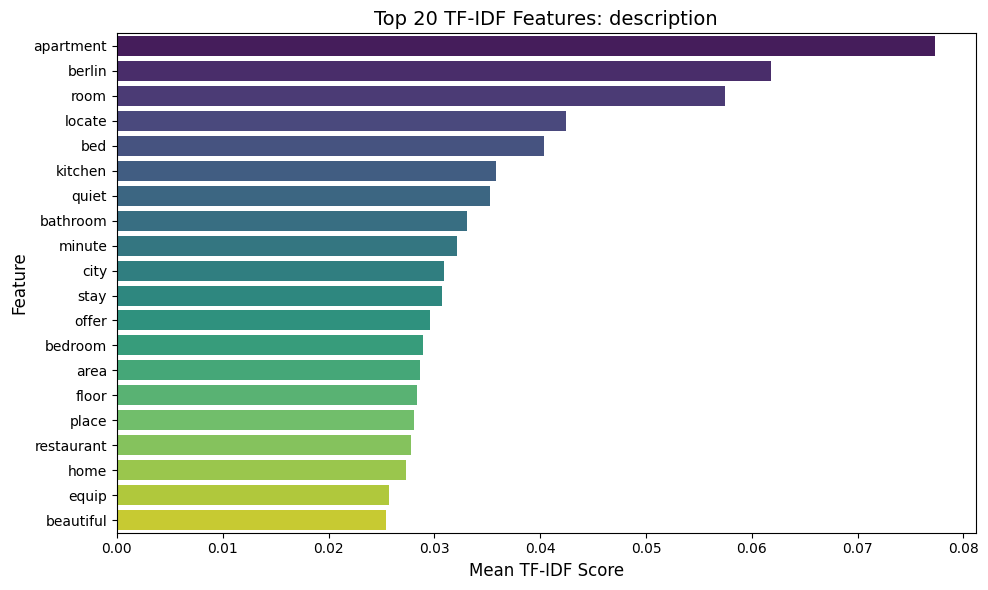

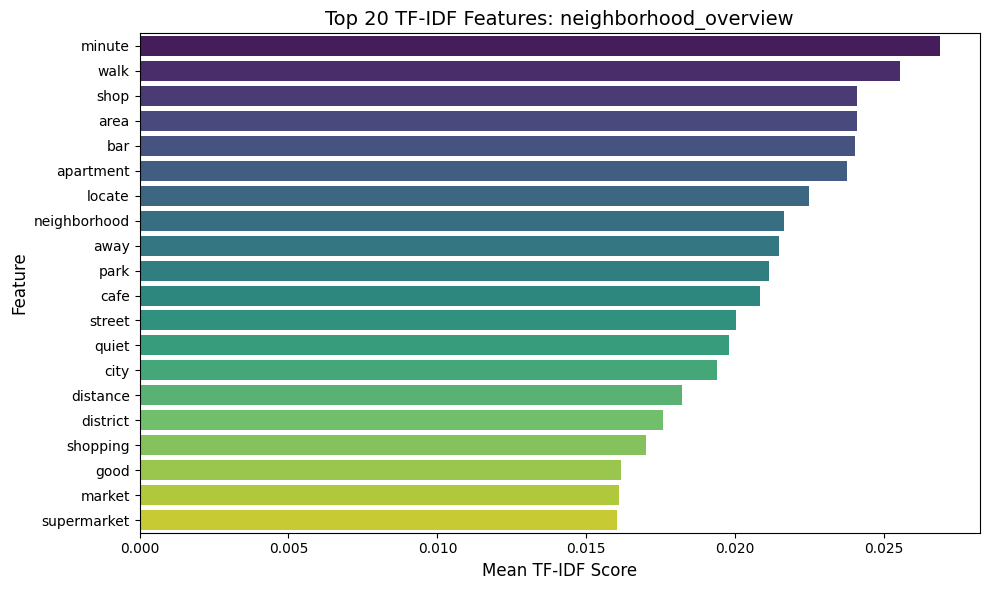

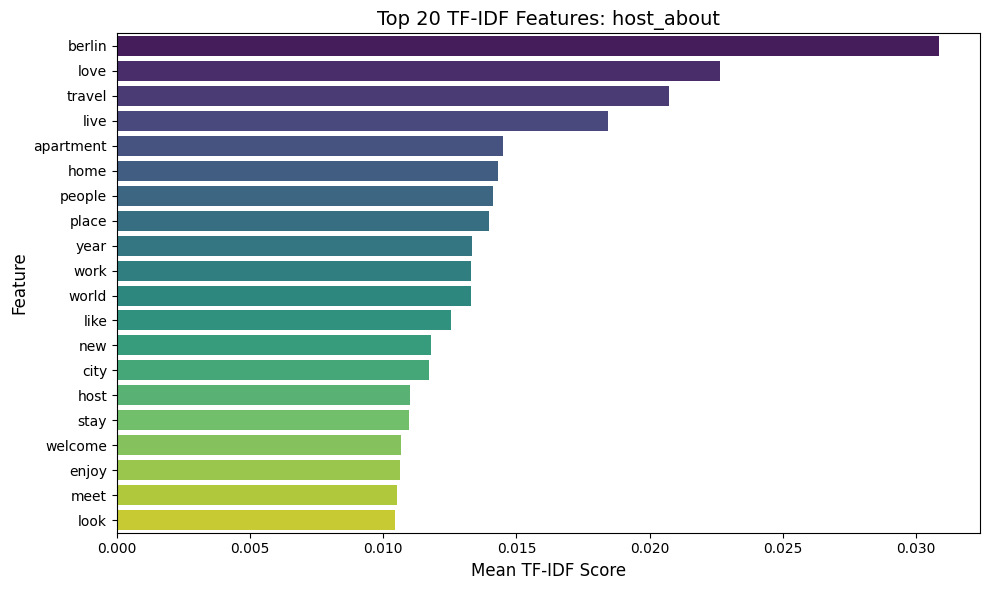

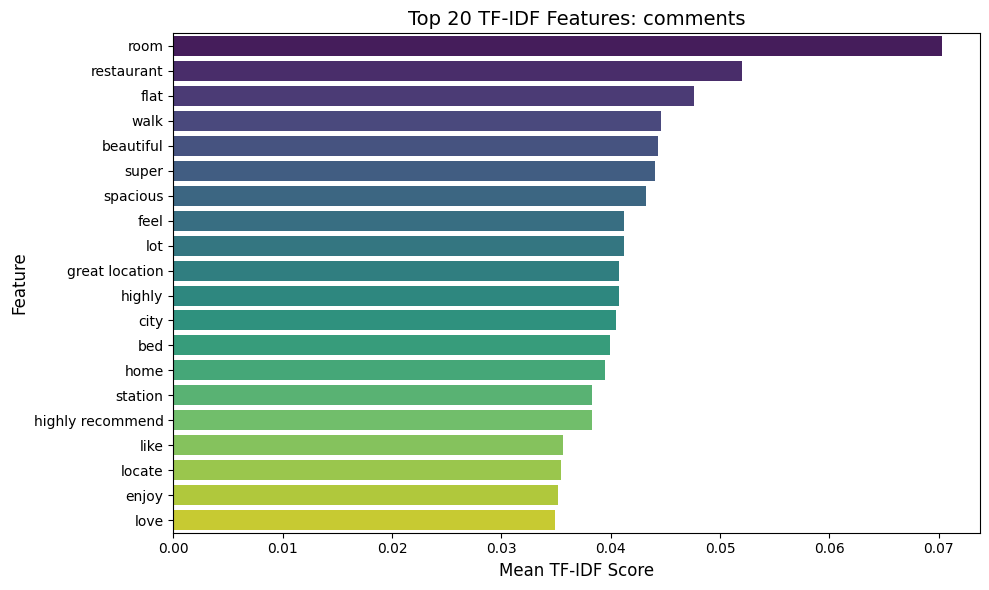

In [148]:
plot_top_tfidf_features(optimized_configs, preprocessed_data_train)

# TEST SET


In [150]:
filtered_data_test = filter_english_and_aggregate(raw_data_test)

  Processing description...


  0%|          | 0/101581 [00:00<?, ?it/s]

  Processing neighborhood_overview...


  0%|          | 0/101581 [00:00<?, ?it/s]

  Processing host_about...


  0%|          | 0/101581 [00:00<?, ?it/s]

  Processing comments...


  0%|          | 0/101581 [00:00<?, ?it/s]

  Aggregating reviews...
After filtering and aggregating: (1367, 6)


In [151]:
preprocessed_data_test = preprocess_data(filtered_data_test)

Preprocessing text data...
Text Statistics:
                       total_texts  non_empty  avg_length  median_length  \
description                 1367.0     1295.0      348.33          403.0   
neighborhood_overview       1367.0      729.0      233.73           92.0   
host_about                  1367.0      421.0       90.86            0.0   
comments                    1367.0     1321.0     9511.58         3125.0   

                       max_length  unique_texts  
description                 575.0        1235.0  
neighborhood_overview      1000.0         639.0  
host_about                 2002.0         334.0  
comments                 165253.0        1302.0  
  Cleaning description...
  Cleaning neighborhood_overview...
  Cleaning host_about...
  Cleaning comments...
  Filtering short texts...
Removed 4 rows with insufficient text
Final dataset size: 1363 rows


In [152]:
features_test = create_optimized_features(preprocessed_data_test, optimized_configs, is_train=False)

Transforming optimized TF-IDF features...
  Creating numeric features...
Final feature matrix shape: (1363, 3515)


In [153]:
features_test.to_csv('features_test.csv', index=False)

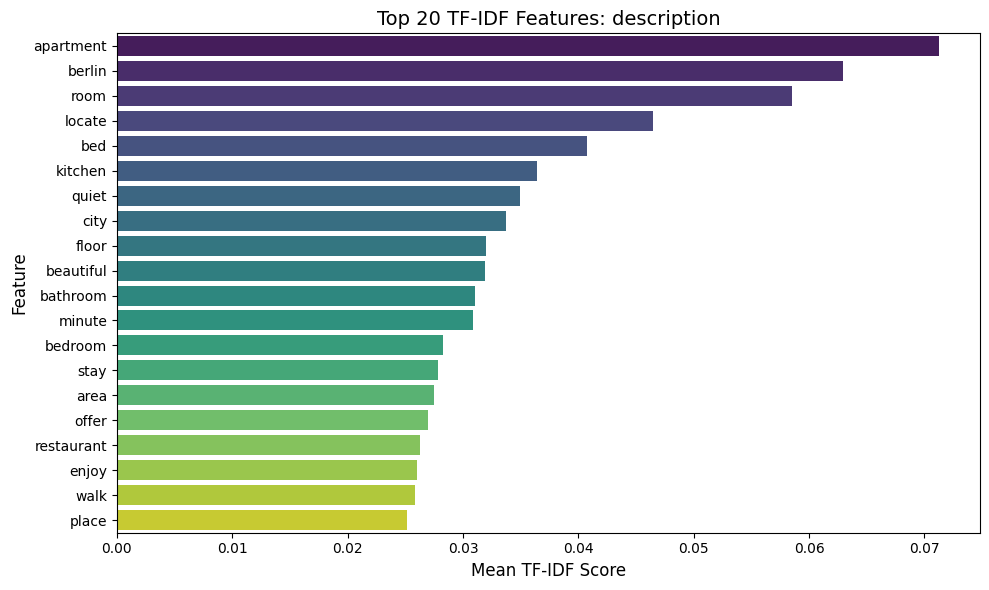

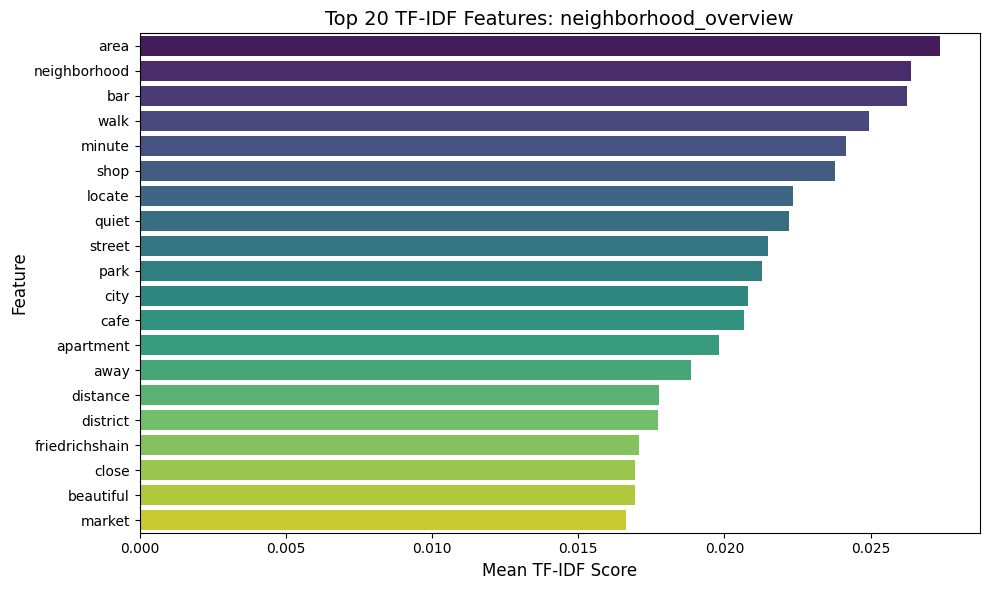

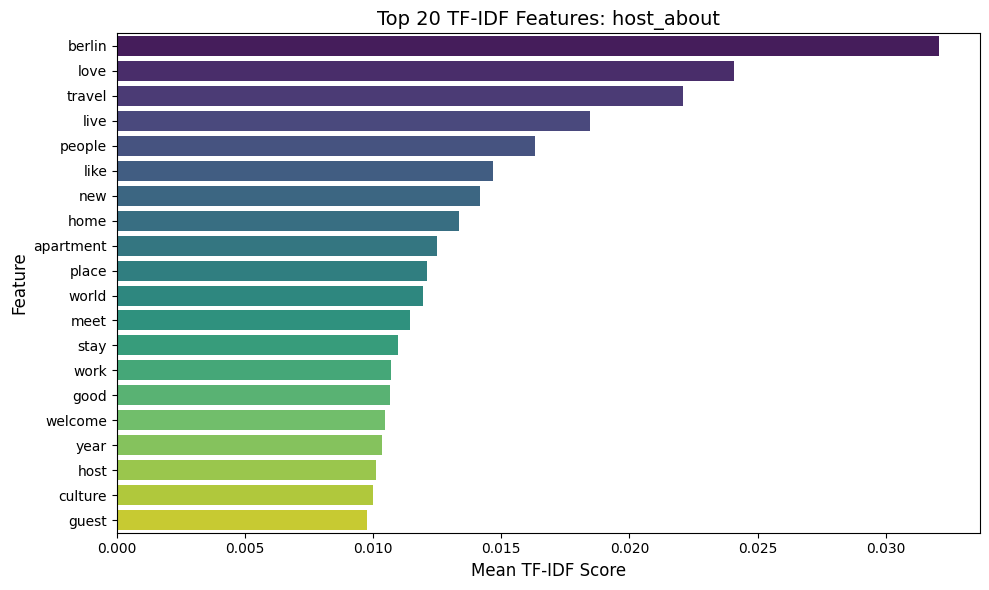

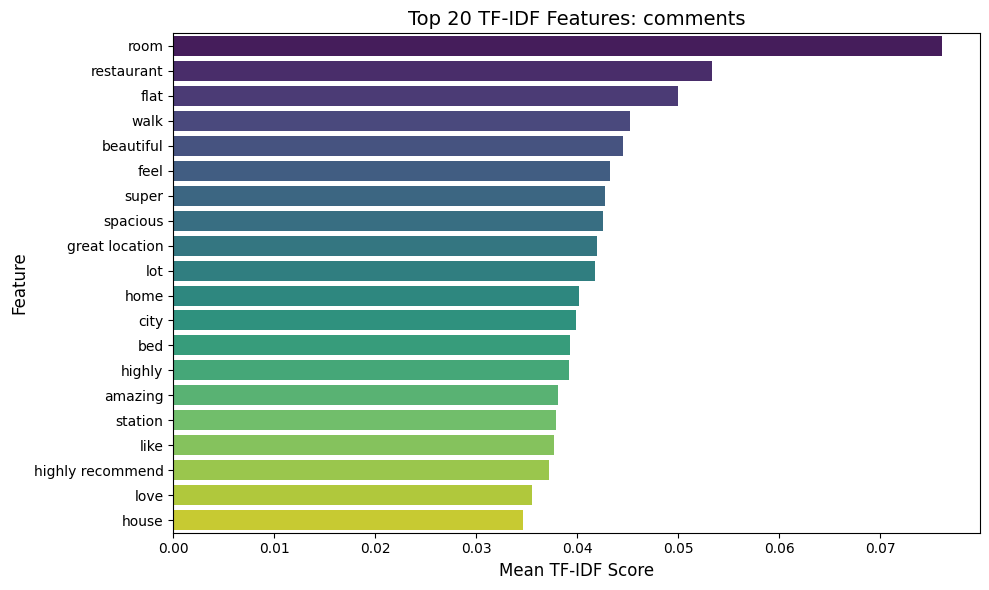

In [154]:
plot_top_tfidf_features(optimized_configs, preprocessed_data_test)

In [156]:
features_train.shape,features_test.shape


((5452, 3517), (1363, 3517))